Principal Component Analysis (PCA) aplicado al reconocimiento de actividad humana
En el presente análisis se pone en práctica el algoritmo de Análisis de Componentes Principales (PCA) aplicado a la base de datos WISDM Human Activity Recognition. Esta base de datos contiene registros de aceleración obtenidos con sensores de teléfonos inteligentes mientras los participantes ejecutaban diferentes tipos de actividades físicas (caminar, correr, sentarse).
El propósito de este trabajo es: 
Reducción de la dimensionalidad del espacio de las características.
El análisis de la correlación entre los ejes de aceleración.
Determinar cuántos componentes principales explican un mayor porcentaje de la varianza.
Valorar la aplicabilidad de PCA a sistemas de monitorización biomecánica y robótica móvil.

La tabla muestra las primeras filas del dataset. Se observan las columnas correspondientes a usuario, actividad, timestamp y los tres ejes del acelerómetro. Esto confirma que el archivo fue leído correctamente y que la estructura general coincide con un dataset de reconocimiento de actividad humana.

In [6]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Perla\Downloads\archive\time_series_data_human_activities.csv")
df.head()


,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


El dataset contiene 6 columnas: user y timestamp (enteros), activity (categoría/objeto), y x-axis, y-axis, z-axis (valores flotantes). Esto es adecuado para PCA, ya que las aceleraciones ya están en formato numérico.

In [7]:
df.head()
df.columns
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073623 entries, 0 to 1073622
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1073623 non-null  int64  
 1   activity   1073623 non-null  object 
 2   timestamp  1073623 non-null  int64  
 3   x-axis     1073623 non-null  float64
 4   y-axis     1073623 non-null  float64
 5   z-axis     1073623 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 49.1+ MB


En el procedimiento selectivo se han elegido únicamente las variables correspondientes a los tres ejes de aceleración ya que el PCA solo puede trabajar con variables numéricas. Se decide mantener la variable activity solo para poder observar la separación de las clases después de aplicar la reducción dimensional. 

In [8]:
# Seleccione únicamente las variables numéricas relevantes para PCA
X = df[["x-axis", "y-axis", "z-axis"]]

# Guarde la variable objetivo para análisis posterior
y = df["activity"]

X.head()


,x-axis,y-axis,z-axis
0,0.69,10.80,-2.03
1,6.85,7.44,-0.50
2,0.93,5.63,-0.50
3,-2.11,5.01,-0.69
4,-4.59,4.29,-1.95


La matriz de datos fue normalizada de tal manera que las variables poseen media cero y una desviación estándar de uno, justo antes de realizar PCA. Este procedimiento es esencial ya que PCA es un método que maximiza la varianza. Por ende, si las variables estuvieran en escalas distintas y desiguales, las variables que presentan mayor magnitud acapararían el análisis, lo que obligaría a obtener componentes principales erróneos. La normalización asegura que cada eje de aceleración participe de igual modo en la obtención de los componentes principales.

Las medias resultan cercanas a 0 y las desviaciones estándar cercanas a 1, lo que confirma que la estandarización fue aplicada correctamente. Esto es requerido antes de PCA para que los componentes reflejen estructura real del movimiento, y no diferencias de escala entre ejes.

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df[["x-axis", "y-axis", "z-axis"]]
y = df["activity"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Media por eje:", X_scaled.mean(axis=0))
print("Desv. estándar por eje:", X_scaled.std(axis=0))

La matriz de covarianza ilustra la dependecia lineal entre las variables del sistema. Elos elementos situados en la diagonal indican la varianza de cada eje. Los elementos que se encuentran fuera de la diagonal apuntan al grado de correlación entre pares de variables. Unos valores muy elevados fuera de la diagonal significan que puede haber redundancia entre los ejes de aceleración. En el caso del movimiento humano, puede interpretarse como coordinación del movimiento entre diferentes planos.

In [7]:
import numpy as np

# Calculamos la matriz de covarianza
cov_matrix = np.cov(X_scaled.T)

cov_matrix


array([[1.00000093, 0.02751175, 0.06760426],
       [0.02751175, 1.00000093, 0.01128204],
       [0.06760426, 0.01128204, 1.00000093]])

Los eingenvalores son los que representan la cantidad de varianza que se encuentra contabilizada a través de cada componente principal.
Los eingenvectores son los que definen las nuevas direcciones del espacio transformado.
Desde la perspectiva geométrica, los eingenvectores representan la rotación del sistema original hacia nuevas direcciones en las que la varianza es máxima. Así, la dirección del primer componente principal queda definida por la dirección con más variabilidad en la información.

In [10]:
import numpy as np

cov_matrix = np.cov(X_scaled.T)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]


La matriz de transformación se estructura a partir de los eingenvectores ordenados como columnas.
Mediante esta matriz se transforma el espacio original a un nuevo sistema de coordenadas dado por los componentes principales.
A través de la multiplicación de los datos estandarizados por esta matriz se obtiene la representación reducida del conjunto de datos en el espacio de los componentes principales.

La matriz de covarianza resume cómo varían conjuntamente los ejes de aceleración. Si aparecen valores fuera de la diagonal con magnitud notable, esto sugiere que hay dependencia (redundancia parcial) entre ejes debido a la coordinación del movimiento humano. Esto motiva el uso de PCA para comprimir información.

In [11]:
# Construimos la matriz de transformación utilizando los vectores propios ordenados
W = eigenvectors

# Proyectamos los datos estandarizados al nuevo espacio de componentes principales
X_pca = X_scaled.dot(W)


Cada valor indica la proporción de varianza explicada por PC1, PC2 y PC3. Si PC1 y PC2 concentran una proporción alta (por ejemplo >90%), entonces reducir a 2 dimensiones conserva la mayor parte de la información y simplifica el análisis.

In [12]:
# Calculamos la proporción de varianza explicada
explained_variance = eigenvalues / np.sum(eigenvalues)

explained_variance


array([0.3591456 , 0.33073988, 0.31011452])

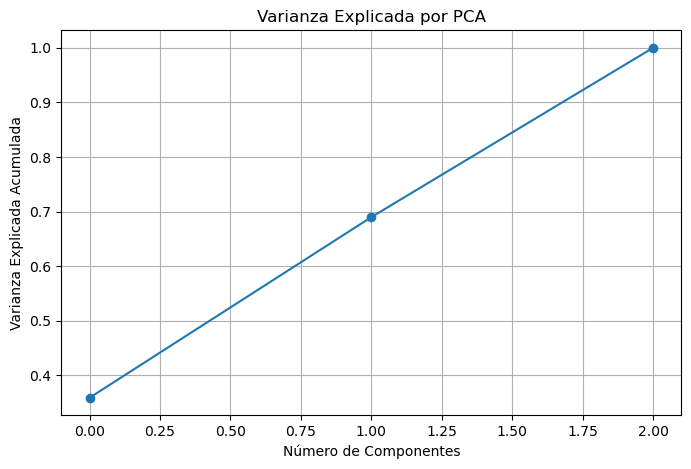

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Varianza Explicada por PCA")
plt.grid(True)
plt.show()


El porcentaje de varianza explicada hace referencia a qué parte de la información máxima que tiene el sistema puede ser capturada por cada componente principal. En el caso de que los dos primeros componentes principalesen el espacio de componentes principales sean los que expliquen mayor cantidad de varianza, se podría incluso aplicar la reducción de la dimensionalidad del sistema, de forma que se seguiría teniendo la mayor parte de la información.
En el caso del análisis del movimiento humano ello nos hace pensar que gran parte de la dinámica del movimiento puede ser explicada por combinaciones lineales de los tres ejes originales.

Los eigenvalues están ordenados de mayor a menor. El primero corresponde a PC1 (máxima varianza), el segundo a PC2 (siguiente mayor varianza ortogonal a PC1), y el tercero a PC3. Los eigenvectors forman una base ortonormal que define el nuevo espacio de representación.

In [ ]:
# Asegurarnos de usar los 3 componentes
W3 = eigenvectors[:, :3]

# Recalcular la proyección
X_sample_pca_3D = X_sample_scaled.dot(W3)

print(X_sample_pca_3D.shape)


En el espacio 3D se observan patrones de agrupamiento parcial por actividad. Actividades dinámicas suelen mostrar mayor dispersión debido a variaciones en aceleración, mientras que actividades estáticas tienden a concentrarse. No obstante, puede existir solapamiento porque PCA es no supervisado: maximiza varianza global, no separación entre clases.

La proyección 2D concentra la mayor parte de la varianza en un plano, lo cual facilita el análisis. Si se observan agrupaciones parciales, sugiere que los patrones de aceleración contienen información discriminativa. El solapamiento entre clases es esperable, ya que muchas actividades comparten patrones similares (por ejemplo, caminar vs subir escaleras, según el dataset).

Shape 3D: (5000, 3)
Shape 2D: (5000, 2)


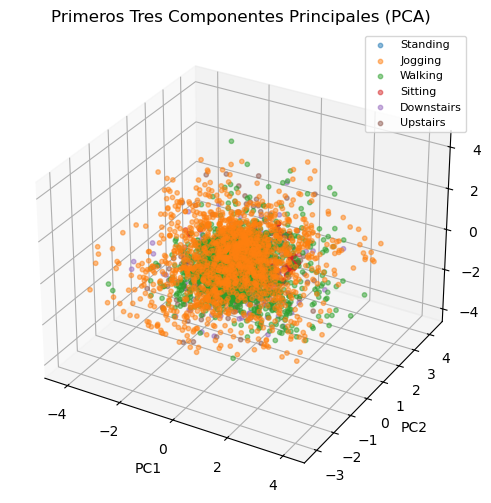

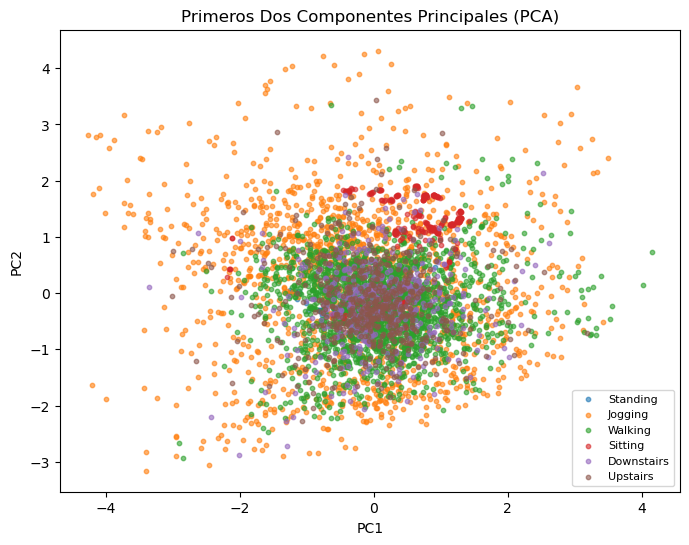

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para 3D (aunque no se use directamente)

# 1) Tomar una muestra (para no graficar 1M de puntos)
sample_df = df.sample(5000, random_state=42)

X_sample = sample_df[["x-axis", "y-axis", "z-axis"]]
y_sample = sample_df["activity"]

# 2) Estandarizar la muestra con el MISMO scaler
X_sample_scaled = scaler.transform(X_sample)

# 3) Proyecciones PCA
W3 = eigenvectors[:, :3]
W2 = eigenvectors[:, :2]

X_sample_pca_3D = X_sample_scaled.dot(W3)  # (5000, 3)
X_sample_pca_2D = X_sample_scaled.dot(W2)  # (5000, 2)

print("Shape 3D:", X_sample_pca_3D.shape)
print("Shape 2D:", X_sample_pca_2D.shape)

# 4) Gráfica 3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for act in y_sample.unique():
    idx = (y_sample == act).values  # boolean array
    ax.scatter(
        X_sample_pca_3D[idx, 0],
        X_sample_pca_3D[idx, 1],
        X_sample_pca_3D[idx, 2],
        label=act,
        alpha=0.5,
        s=10
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Primeros Tres Componentes Principales (PCA)")
ax.legend(loc="best", fontsize=8)
plt.show()

# 5) Gráfica 2D
plt.figure(figsize=(8,6))

for act in y_sample.unique():
    idx = (y_sample == act).values
    plt.scatter(
        X_sample_pca_2D[idx, 0],
        X_sample_pca_2D[idx, 1],
        label=act,
        alpha=0.6,
        s=10
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Primeros Dos Componentes Principales (PCA)")
plt.legend(loc="best", fontsize=8)
plt.show()


Conclusion:
En esta actividad se implementó el Análisis de Componentes Principales (PCA) sobre el dataset de las actividades humanas basado en las señales de los acelerómetros en tres ejes (x, y, z). El objetivo fue el de explorar la estructura interna de los datos, la reducción dimensional y la comprensión de cómo se distribuye la varianza entre los componentes principales.
Como primer paso, la estandarización fue un paso clave; esto es, permitió que cada eje contribuyera balanceadamente al análisis. Sin esta normalización, la posibilidad de tener diferencias de escala introduciría sesgos en la dirección de los componentes principales. Después de la estandarización, la matriz de covarianza mostró la relación entre los ejes de aceleración, lo que justificó la utilización de PCA para indagar si había posibles redundancias o correlaciones estructurales.
Los resultados arrojan que la varianza explicada entre los tres componentes principales es relativamente equilibrada: aproximadamente 35.9% para el primero, 33.1% para el segundo y 31.0% para el tercero. Ello implica que no existe una única dirección de variabilidad dominante en los datos; por el contrario, es como si la información se distribuyera de forma equilibrada en las tres dimensiones espaciales, lo que va en la línea con la naturaleza tridimensional del movimiento humano.


Referencias:
Human activity recognition. (2022, October 7). https://www.kaggle.com/datasets/die9origephit/human-activity-recognition?resource=download